In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D
# import time
import pickle
import random


import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive

import os
os.getcwd()

# np.set_printoptions(threshold=sys.maxsize)

'/home/thabib/Documents/Personal/Master_Thesis/1_HTMImplementation'

The following code allows us to generate random valid grammar strings:
(Source: https://www.deep-teaching.org/notebooks/sequence-learning/exercise-pytorch-char-rnn-reber-grammar)

In [20]:
chars='ATSXPVZ'
emb_chars = 'TP'

graph = [[(1,5),('T','P')] , [(1,2),('S','X')], \
           [(3,5),('V','X')], [(6,),('Z')], \
           [(4,2,3),('T','P','S')], [(4,),('V')] ]

In [116]:
class Reber_Grammar():
    
    def __init__(self, N, k):
        """
        Initializer function.
        
        Parameters
        ----------
        N : int
            DESCRIPTION.
        k : int
            DESCRIPTION.
        erg : BOOLEAN, optional
            DESCRIPTION. The default is False.

        Returns
        -------
        None.

        """
        
        self.chars = chars
        self.emb_chars = emb_chars
        self.graph = graph
        
        self.N = N
        self.k = k
        
        self.df_CharsToMinicols = pd.DataFrame() # DataFrame with cols: 'A', 'T', 'P', etc. each with 'k'
                                                 # minicolumn indices corresponding to that character.
        minicolumns = np.arange(self.N)
        random.shuffle(minicolumns)
        
        for i, sym in enumerate(self.chars):
            mc = minicolumns[i*self.k:(i+1)*self.k]
            self.df_CharsToMinicols[sym] = np.sort(mc, kind='mergesort')
        
        return None
        
        
    
    def generateSequences(self, minLength=5):
        """
        Function to generate one SRG string (alphabet form) and 
        list of possible next transitions.        
        
        Parameters
        ----------
        minLength : int, optional
            Minimum length of the SRG string. The default is 5.

        Returns
        -------
        inchars : list of str; an array of chars generated from SRG. Ex: ['A', 'P', 'V', 'T', 'S', 'Z']
        outchars : list of tuples of str; an array of next possible transitions from each char in the first entry. 
        Ex: [('T', 'P'), 'V', ('T', 'P', 'S'), ('T', 'P', 'S'), 'Z']

        """
        
        while True:
            inchars = ['A']
            node = 0
            outchars = []    
            
            while node != 6:
                transitions = graph[node]
                i = np.random.randint(0, len(transitions[0]))
                inchars.append(transitions[1][i])
                outchars.append(transitions[1])
                node = transitions[0][i]
            
            if len(inchars) > minLength:  
                return inchars, outchars
            
            
    def get_one_srg(self, minLength=5):
        """
        To generate one SRG string in one-hot vector form (with respect to the minicolumns)
        and its corresponding list of possible next transitions.
        
        Parameters
        ----------
        minLength : int, optional
            Minimum length of the SRG string. The default is 5.

        Returns
        -------
        inseq_oh : list of binary ndarray;
        outseq_oh : list of binary ndarray;

        """
        
        inchars, outchars = self.generateSequences(minLength)
        
        
        inseq_oh = []
        outseq_oh = []
        
        for i_ch,o_ch in zip(inchars, outchars): 
            inpt = np.zeros(self.N)
            inpt[self.df_CharsToMinicols[i_ch]] = 1     
            outpt = np.zeros(self.N)
            
            for o in o_ch:
                outpt[self.df_CharsToMinicols[o]] = 1
            
            inseq_oh.append(inpt)
            outseq_oh.append(outpt)
        
        return inseq_oh, outseq_oh
    
    
    def get_n_srg(self, n, minLength=5):
        """
        Generate 'n' SRG string examples in one-hot encoding (wrt minicolumns).

        Parameters
        ----------
        n : int; No. of SRG examples to generate.
        minLength : int, optional
            Minimum length of the SRG string. The default is 5.

        Returns
        -------
        examples : list; list of 'n' examples of SRG strings, along with list
        of possible next transitions.

        """
        examples = []
        
        for i in range(n):
            examples.append(self.get_one_srg(minLength))
        
        return examples
    
    
    def OnehotToWord(self, sequence):
        """
        converts a sequence (one-hot) back to a RG string.
        
        Parameters
        ----------
        sequence : list of binary ndarray; Given Reber String in one-hot encoding.

        Returns
        -------
        reberString : list of str; Reber string in alphabet.

        """
    
        reberString = ''
        
        for s in sequence:
            index = np.where(s==1)[0][0]
            reberString += self.df_CharsToMinicols.columns[np.where(self.df_CharsToMinicols==index)[1][0]]
        reberString+='Z'
        
        return reberString
    
    
    def in_grammar(self, word):
        """
        To check if a given character String is in the Reber Grammar.

        Parameters
        ----------
        word : string;

        Returns
        -------
        bool; True, if the string is a valid string of RG.

        """
        if word[0] != 'A':
            return False
      
        node = 0    
        
        for c in word[1:]:
            transitions = graph[node]
            try:
                node = transitions[0][transitions[1].index(c)]
            except ValueError: # using exceptions for flow control in python is common
                return False
        
        return True  

    
    def hist_len_rg(self, rg_exs):
        """
        Plots histogram of the lengths of the generated reber grammar strings.

        Parameters
        ----------
        rg_exs : list of reber grammar strings.

        Returns
        -------
        None.

        """
        
        len_rg_exs = []

        for ex in rg_exs:
            len_rg_exs.append(len(ex[0]))
        
        plt.figure()
        plt.hist(len_rg_exs)
        plt.show()
        
        return
    
# ______________________________For ERG strings________________________________
    
    def get_one_erg(self, minLength=5):
        """
        To generate one ERG string in one-hot vector form (with respect to the minicolumns)
        and its corresponding list of possible next transitions.

        Parameters
        ----------
        minLength : int, optional
            Minimum length of the ERG string. The default is 5.

        Returns
        -------
        emb_in_oh : list of binary ndarray;
            DESCRIPTION.
        emb_out_oh : TYPE
            DESCRIPTION.

        """
        
        simple_in_oh, simple_out_oh = self.get_one_srg()
        
        emb_in_oh = simple_in_oh[:] # contains the one-hot encoded SRG, except the final 'Z'
        emb_out_oh = simple_out_oh[:]
        
        # Selecting one of 'T' or 'P' for embedding and computing its one-hot encoding
        emb_char = emb_chars[np.random.randint(0, len(emb_chars))]
        emb_char_oh = np.zeros(self.N)
        emb_char_oh[self.df_CharsToMinicols[emb_char]] = 1    
    
        # Entering the embedded char's one-hot encoding at the second position    
        emb_in_oh[1:1] = [emb_char_oh] 
        # Entering the embedded char's one-hot encoding at the last position
        emb_in_oh.insert(len(emb_in_oh), emb_char_oh) 
        #### print('Embedded INPUT string:', OnehotToWord(emb_in))
        
        # Entering the predictions of 'T' and 'P' at the second position
        emb_out_oh[1:1] = [simple_out_oh[0]]
        # Entering the prediction of embedded char at the second last position
        emb_out_oh.insert(len(emb_out_oh)-1, emb_char_oh)
    
        return emb_in_oh, emb_out_oh
    
    
    def get_n_erg(self, n, minLength=5):
        """
        Generate 'n' ERG string examples in one-hot encoding (wrt minicolumns).

        Parameters
        ----------
        n : int; No. of SRG examples to generate.
        minLength : int, optional
            Minimum length of the SRG string. The default is 5.

        Returns
        -------
        examples : list; list of 'n' examples of ERG strings, along with list
        of possible next transitions.

        """
        examples = []
        
        for i in range(n):
            examples.append(self.get_one_erg(minLength))
        
        return examples
    
    
    

In [117]:
rg = Reber_Grammar(175, 25)

In [118]:
rg.generateSequences()
# ATSXPVZ

(['A', 'T', 'S', 'X', 'X', 'V', 'T', 'S', 'Z'],
 [('T', 'P'),
  ('S', 'X'),
  ('S', 'X'),
  ('V', 'X'),
  'V',
  ('T', 'P', 'S'),
  ('T', 'P', 'S'),
  'Z'])

In [119]:
rg.df_CharsToMinicols

,A,T,S,X,P,V,Z
0,13,8,4,1,0,2,26
1,20,12,5,3,6,19,37
2,25,14,9,7,16,34,40
3,29,21,10,11,17,38,48
4,33,23,22,15,18,45,49
5,42,31,24,27,30,51,64
6,43,32,28,53,35,52,70
7,56,46,36,63,50,55,71
8,68,47,39,76,60,58,81
9,69,67,41,79,72,62,86


In [125]:
rg.get_one_srg()

([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 1., 0.]),
  array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 

In [121]:
rg.get_n_srg(5)[0][1]

[array([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.]),
 array([0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.

In [54]:
rg.OnehotToWord(rg.get_n_srg(5)[3][0])

'APVPVZ'

In [82]:
rg.in_grammar(rg.OnehotToWord(rg.get_n_srg(5)[3][0]))

True

In [112]:
a = rg.get_n_erg(1000)

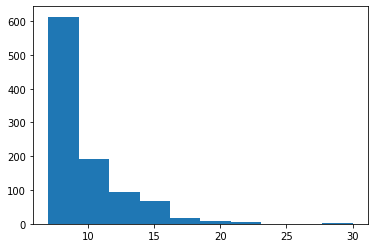

In [114]:
rg.hist_len_rg(a)

In [17]:
c=0
for i in len_erg_examples:
    if i>20:
        c+=1
c    

96

In [126]:
a = [(1,2),(2,2),(3,1)]
b = [a[i][0] for i in range(len(a))]
print(b)

[1, 2, 3]


# :::::::::::::::::::::::::::::::::::ROUGH::::::::::::::::::::::::::::::::::::::::::::::::::::::

## Calculation of Probability for a False Match of SDRs

In [14]:
from scipy.special import comb as ncr
    
def false_match_prob(a,n,s,th):
    summ = 0
    for i in range(th, s+1):
        summ += ncr(s,i, exact=True)*ncr(n-s,a-i, exact=True)
    
    prob = summ/ncr(n,a, exact=True)
    return prob

a = 40 # value of 'k'
n = 65536 # total cells in network
s = 128 # number of connected synapses on a dendritic segment
th = 15  # NMDA threshold 
        
false_match_prob(a,n,s,th)

3.7848536276106233e-31

In [94]:
chars='TSXPV#'
emb_chars = 'TP'

graph = [[(1,5),('T','P')] , [(1,2),('S','X')], \
           [(3,5),('V','X')], [(6,),('#')], \
           [(4,2,3),('T','P','S')], [(4,),('V')] ]


# TO GENERATE SEQUENCES OF SRG
def generateSequences(minLength=5):
    """
    Returns a tuple with
    first entry: as array of chars generated from SRG
    second entry: as array of next possible transitions from each char in the first entry
    """
    while True:
        node = 0
        inchars = []
        outchars = []    
        while node != 6:
            transitions = graph[node]
            i = np.random.randint(0, len(transitions[0]))
            inchars.append(transitions[1][i])
            outchars.append(transitions[1])
            node = transitions[0][i]
        if len(inchars) > minLength:  
            return inchars, outchars
        
        
# TO GENERATE ONE-HOT ENCODINGS OF THE OUTPUT ARRAYS OF 'generateSequences()' function
def get_one_srg(minLength=5):
    inchars, outchars = generateSequences(minLength)
    inseq = []
    outseq= []
    for i,o in zip(inchars, outchars): 
        inpt = np.zeros(6)
        inpt[chars.find(i)] = 1.     
        outpt = np.zeros(6)
        for oo in o:
            outpt[chars.find(oo)] = 1.
        inseq.append(inpt)
        outseq.append(outpt)
    return inseq, outseq


# TO CONVERT BACK INTO SYMBOLS FROM THE ONE-HOT ENCODINGS
def OnehotToWord(sequence):
    """
    converts a sequence (one-hot) in a reber string
    """
    reberString = ''
    for s in sequence:
        index = np.where(s==1.0)[0][0]
        reberString += chars[index]
    reberString+='#'
    return reberString


def get_n_srg(n, minLength=5):
    examples = []
    for i in range(n):
        examples.append(get_one_srg(minLength))
    return examples



# ____________________________________For ERG strings__________________________________________#


def get_char_onehot(char):
    char_oh = np.zeros(6)
    if chars.find(char) == -1:
        print('Character NOT in Grammar')
        return
    else:
        char_oh[chars.find(char)] = 1.
    return char_oh 


def get_one_erg(minLength=5):
    
    simple_in, simple_out = get_one_srg()
    emb_in = simple_in[:]
    emb_out = simple_out[:]
    
    emb_char = emb_chars[np.random.randint(0, len(emb_chars))]
    emb_char_oh = get_char_onehot(emb_char)
    
    emb_in[1:1] = [emb_char_oh]
    emb_in.insert(len(emb_in), emb_char_oh)
    print('Embedded INPUT string:', OnehotToWord(emb_in))
    
    emb_out[1:1] = [simple_out[0]]
    emb_out.insert(len(emb_out)-1, get_char_onehot(emb_char))

    return emb_in, emb_out


def get_n_erg(n, minLength=5):
    examples = []
    for i in range(n):
        examples.append(get_one_erg(minLength))
    return examples


def in_grammar(word):
    node = 0    
    for c in word[1:]:
        transitions = graph[node]
        try:
            node = transitions[0][transitions[1].index(c)]
        except ValueError: # using exceptions for flow control in python is common
            return False
    return True        

In [ ]:
in_seq, out_seq = get_one_embedded_example(minLength=5)

print('Input sequence starting at char index 0 until the second to the last:\n')
print(in_seq)
print('-----------------------------------')
print('Input sequence as character:')
print(sequenceToWord(in_seq))
print('-----------------------------------')
print('Target sequence starting at char index 1 until the last')
print(sequenceToWord(out_seq))
print('-----------------------------------')
print('Validate a string:')
### Append 'E' to input sequence as char at last index is ommited
print(in_grammar(sequenceToWord(in_seq)+'E'))

In [ ]:
print(chars)

simple_in, simple_out = get_one_example()
print('\nSimple INPUT string (one-hot):', simple_in)
# print(o)

emb_char = emb_chars[np.random.randint(0, len(emb_chars))]
print('\nThis is embedded char:', emb_char)

oh_emb_char = get_char_one_hot(emb_char)
# print('\nThis is embedded chars one-hot encoding:', oh_emb_char)

emb_in = simple_in[:]
# print('\nString before embedding:', emb_in)
emb_in[1:1] = [oh_emb_char]
# print('\nString after front embedding:', emb_in)
emb_in.insert(len(emb_in), oh_emb_char)
# print('\nString after end embedding:', emb_in)
print('\nEmbedded INPUT string:', sequenceToWord(emb_in))

print('\n\n\n Simple OUTPUT string (one-hot):', simple_out)
print('\n Length of Simple OUTPUT string: ', len(simple_out))
emb_out = simple_out[:]
emb_out[1:1] = [simple_out[0]]
emb_out.insert(len(emb_out)-1, simple_out[0])
print('\nEmbedded OUTPUT string (one-hot):', emb_out)
print('\n Length of Embedded OUTPUT string: ', len(emb_out))